### Carga del Dataset

In [25]:
import pandas as pd

ruta_csv = r"data\StudentsPerformance.csv"

df = pd.read_csv(ruta_csv)
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Selección de variables numéricas relevantes

In [26]:
print(df.columns)

columnas_numericas = ['math score', 'reading score', 'writing score']

# Subconjunto de datos solo con esas columnas
X = df[columnas_numericas].copy()

# Comprobación rápida de valores faltantes
print("\nValores nulos por columna:")
print(X.isnull().sum())

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

Valores nulos por columna:
math score       0
reading score    0
writing score    0
dtype: int64


### Preprocesamiento: Estandarización de las calificaciones

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Forma del arreglo estandarizado:", X_scaled.shape)

Forma del arreglo estandarizado: (1000, 3)


### Entrenamiento DBSCAN

In [28]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

eps_ini = 0.3
min_ini = 3

resultados_dbscan = []

db_base = DBSCAN(eps=eps_ini, min_samples=min_ini)
labels_base = db_base.fit_predict(X_scaled)

# Contar clusters sin incluir ruido
n_clusters_base = len(set(labels_base)) - (1 if -1 in labels_base else 0)

# Calcular métricas
if n_clusters_base < 2:
    sil_base, ch_base, db_base_val = 0, 0, 0
else:
    mask = labels_base != -1
    X_valid = X_scaled[mask]
    y_valid = labels_base[mask]

    if len(set(y_valid)) < 2:
        sil_base, ch_base, db_base_val = 0, 0, 0
    else:
        sil_base = silhouette_score(X_valid, y_valid)
        ch_base = calinski_harabasz_score(X_valid, y_valid)
        db_base_val = davies_bouldin_score(X_valid, y_valid)

# Agregar SIEMPRE el resultado
resultados_dbscan.append({
    'Eps': eps_ini,
    'Min Samples': min_ini,
    'Silhouette': sil_base,
    'Calinski-Harabasz': ch_base,
    'Davies-Bouldin': db_base_val
})

df_dbscan_incial = pd.DataFrame(resultados_dbscan)
df_dbscan_incial.head()

,Eps,Min Samples,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.3,3,0.0804,38.192458,0.45732


### Búsqueda de hiperparámetros (DBSCAN)

In [18]:
# Rango de búsqueda para eps y min_samples
eps_values = np.arange(0.3, 1.1, 0.1)
min_samples_values = range(3, 11)

resultados_dbscan_optimizado = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Número de clusters
        etiquetas_unicas = set(labels)
        if -1 in etiquetas_unicas:
            etiquetas_unicas.remove(-1)
        n_clusters = len(etiquetas_unicas)

        # Si hay menos de 2 clusters válidos, no se pueden calcular bien las métricas
        if n_clusters < 2:
            silhouette = np.nan
            ch_index = np.nan
            db_index = np.nan
        else:
            # Filtramos ruido para el cálculo de métricas
            mask_no_noise = labels != -1
            X_valid = X_scaled[mask_no_noise]
            labels_valid = labels[mask_no_noise]

            silhouette = silhouette_score(X_valid, labels_valid)
            ch_index = calinski_harabasz_score(X_valid, labels_valid)
            db_index = davies_bouldin_score(X_valid, labels_valid)

        resultados_dbscan_optimizado.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "silhouette": silhouette,
            "calinski_harabasz": ch_index,
            "davies_bouldin": db_index
        })

df_dbscan = pd.DataFrame(resultados_dbscan_optimizado)
df_dbscan.head()

,eps,min_samples,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,0.3,3,5,0.080400,38.192458,0.457320
1,0.3,4,3,0.105746,55.664361,0.653174
2,0.3,5,3,0.174579,77.794146,0.468580
3,0.3,6,3,0.188115,74.597029,0.452383
4,0.3,7,4,0.074481,70.817839,0.518664


In [19]:
# Filtramos filas con métricas válidas
df_dbscan_valid = df_dbscan.dropna(subset=["silhouette", "calinski_harabasz", "davies_bouldin"])
df_dbscan_valid = df_dbscan_valid[df_dbscan_valid["n_clusters"] >= 2]

# Ordenamos por Silhouette descendente (mayor es mejor)
df_dbscan_mejores = df_dbscan_valid.sort_values(by="silhouette", ascending=False)

print("Mejores configuraciones DBSCAN (top 10):")
df_dbscan_mejores.head(10)

Mejores configuraciones DBSCAN (top 10):


,eps,min_samples,n_clusters,silhouette,calinski_harabasz,davies_bouldin
17,0.5,4,2,0.526268,41.378688,0.375982
29,0.6,8,2,0.486336,49.893661,0.409149
30,0.6,9,2,0.486336,49.893661,0.409149
19,0.5,6,2,0.484142,42.610698,0.403911
20,0.5,7,2,0.484142,42.610698,0.403911
8,0.4,3,3,0.472149,32.427766,0.403474
9,0.4,4,2,0.463349,26.660534,0.388950
7,0.3,10,3,0.196163,94.609520,0.472011
6,0.3,9,3,0.190826,90.781323,0.467334
3,0.3,6,3,0.188115,74.597029,0.452383


### Implementación de Algoritmos Optimizados

#### DBSCAN

In [20]:
if not df_dbscan_mejores.empty:
    best_row = df_dbscan_mejores.iloc[0]
    best_eps = best_row["eps"]
    best_min_samples = int(best_row["min_samples"])

    print(f"Mejor configuración DBSCAN encontrada: eps={best_eps}, min_samples={best_min_samples}")
    print("Métricas asociadas:")
    print(best_row)

    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels_dbscan = dbscan_best.fit_predict(X_scaled)

    df["cluster_dbscan"] = labels_dbscan
else:
    print("No se encontró una configuración adecuada de DBSCAN con al menos 2 clusters válidos.")
    labels_dbscan = None

Mejor configuración DBSCAN encontrada: eps=0.5, min_samples=4
Métricas asociadas:
eps                   0.500000
min_samples           4.000000
n_clusters            2.000000
silhouette            0.526268
calinski_harabasz    41.378688
davies_bouldin        0.375982
Name: 17, dtype: float64


#### Clustering Jerárquico (Ward) + Dendrograma

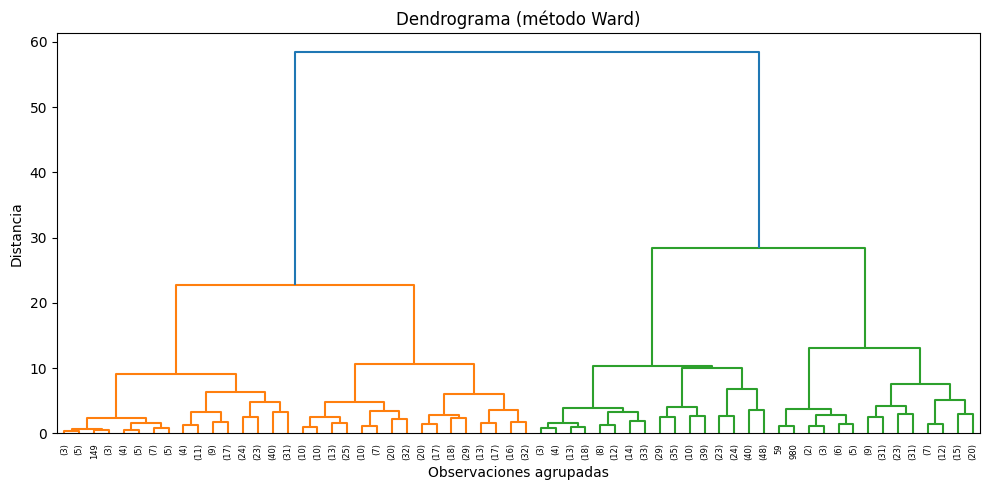

Número de clusters jerárquicos: 3


(array([0, 1, 2], dtype=int64), array([481, 166, 353], dtype=int64))

In [21]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Para el dendrograma se usa la función linkage de SciPy
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrograma (método Ward)")
plt.xlabel("Observaciones agrupadas")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

n_clusters_hier = 3

agg = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
labels_hier = agg.fit_predict(X_scaled)

df["cluster_hier"] = labels_hier

print("Número de clusters jerárquicos:", n_clusters_hier)
np.unique(labels_hier, return_counts=True)

### Evaluación

#### Métricas para Clustering Jerárquico

In [22]:
silhouette_hier = silhouette_score(X_scaled, labels_hier)
ch_hier = calinski_harabasz_score(X_scaled, labels_hier)
db_hier = davies_bouldin_score(X_scaled, labels_hier)

print("Métricas Clustering Jerárquico (Ward):")
print("Silhouette Score:", silhouette_hier)
print("Calinski-Harabasz:", ch_hier)
print("Davies-Bouldin:", db_hier)

Métricas Clustering Jerárquico (Ward):
Silhouette Score: 0.37368405585398173
Calinski-Harabasz: 1189.265711595901
Davies-Bouldin: 0.8297286451619775


#### Comparación DBSCAN vs Jerárquico

In [23]:
# Para DBSCAN, se recalcula métricas usando solo puntos no ruido.
if labels_dbscan is not None and np.any(labels_dbscan != -1) and len(set(labels_dbscan)) > 2:
    mask_no_noise = labels_dbscan != -1
    X_db = X_scaled[mask_no_noise]
    labels_db = labels_dbscan[mask_no_noise]

    silhouette_db = silhouette_score(X_db, labels_db)
    ch_db = calinski_harabasz_score(X_db, labels_db)
    db_db = davies_bouldin_score(X_db, labels_db)

    comparacion = pd.DataFrame([
        {
            "Algoritmo": "DBSCAN (sin ruido)",
            "Silhouette": silhouette_db,
            "Calinski-Harabasz": ch_db,
            "Davies-Bouldin": db_db
        },
        {
            "Algoritmo": "Jerárquico (Ward)",
            "Silhouette": silhouette_hier,
            "Calinski-Harabasz": ch_hier,
            "Davies-Bouldin": db_hier
        }
    ])
else:
    comparacion = pd.DataFrame([
        {
            "Algoritmo": "Jerárquico (Ward)",
            "Silhouette": silhouette_hier,
            "Calinski-Harabasz": ch_hier,
            "Davies-Bouldin": db_hier
        }
    ])

comparacion

,Algoritmo,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,DBSCAN (sin ruido),0.526268,41.378688,0.375982
1,Jerárquico (Ward),0.373684,1189.265712,0.829729


### Visualización en 2D con PCA

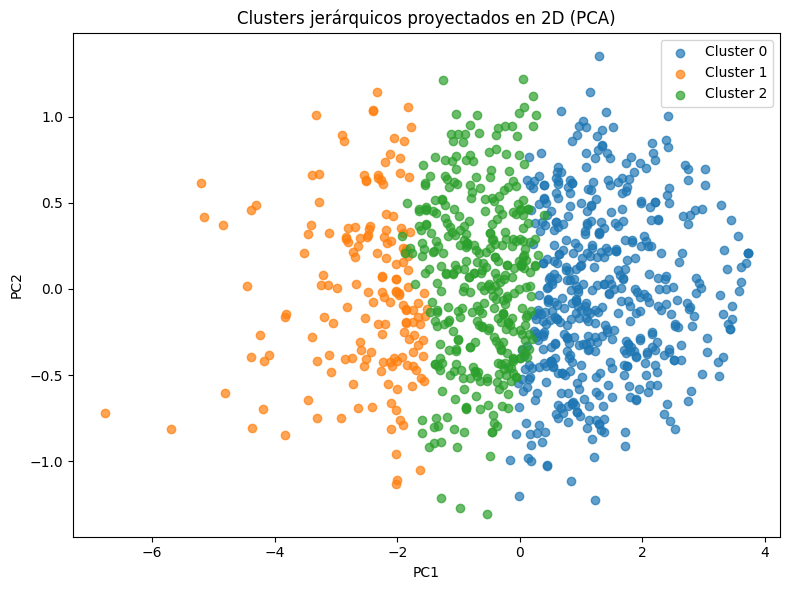

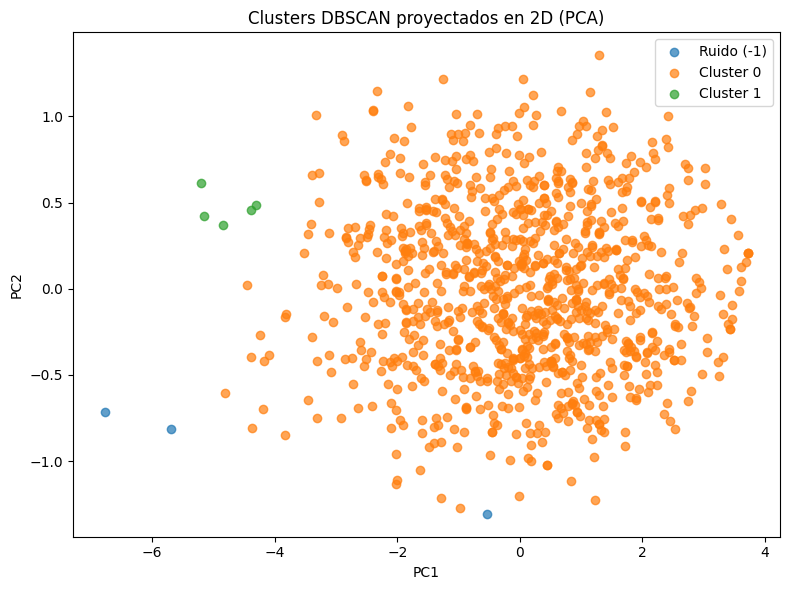

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["cluster_hier"] = df["cluster_hier"]

if "cluster_dbscan" in df.columns:
    df_pca["cluster_dbscan"] = df["cluster_dbscan"]
else:
    df_pca["cluster_dbscan"] = -1  # Solo por compatibilidad

# ---- Gráfico para Clustering Jerárquico ----
plt.figure(figsize=(8, 6))
for cluster_id in sorted(df_pca["cluster_hier"].unique()):
    mask = df_pca["cluster_hier"] == cluster_id
    plt.scatter(df_pca.loc[mask, "PC1"],
                df_pca.loc[mask, "PC2"],
                label=f"Cluster {cluster_id}",
                alpha=0.7)
plt.title("Clusters jerárquicos proyectados en 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Gráfico para DBSCAN (si hay más de un cluster) ----
if labels_dbscan is not None:
    plt.figure(figsize=(8, 6))
    for label in sorted(df_pca["cluster_dbscan"].unique()):
        mask = df_pca["cluster_dbscan"] == label
        if label == -1:
            legend_label = "Ruido (-1)"
        else:
            legend_label = f"Cluster {label}"
        plt.scatter(df_pca.loc[mask, "PC1"],
                    df_pca.loc[mask, "PC2"],
                    label=legend_label,
                    alpha=0.7)
    plt.title("Clusters DBSCAN proyectados en 2D (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()